In [1]:
#from dataset import Dataset
import time
from keras.datasets import cifar10
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.nn.modules.loss import CrossEntropyLoss

import torchvision.datasets as datasets

import sklearn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import hinge_loss

import copy
from copy import deepcopy
import random
import time

import json
import os
from PIL import Image

import tqdm

# EZKL use 3.9.3 ?
import ezkl, onnx

In [2]:
# Class Dictionary for CIFAR10
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

binaryClasses = {0:'Machine', 1:'Animal'} # Machine , Animal

data_mean = (0.4914, 0.4822, 0.4465)
data_std = (0.2470, 0.2435, 0.2616)

## Data Prepartion

In [3]:
from torch.nn.modules.transformer import TransformerDecoderLayer
# Overwrite getitem method to obtain the index of the images when iterating through the images

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader


class CIFAR10(Dataset):
    def __init__(self, train, transform):
        self.cifar10 = torchvision.datasets.CIFAR10(
                        root='./data', train=train, download=True, transform=transform)
        self.targets = self.cifar10.targets
        self.classes = self.cifar10.classes
        self.data = self.cifar10.data


    # Overloaded the getitem method to return index as well
    def __getitem__(self, index):
        data, target = self.cifar10[index]
        return data, target, index

    # Method to get all images' indices from a certain class without iterating through the loader
    def get_index(self, target_label):
      index_list = []
      for index, label in enumerate(self.targets):
        if label == target_label:
          index_list.append(index)
      return index_list

    def __len__(self):
        return len(self.cifar10)

    def remove(self, remove_list):
      mask = np.ones(len(self.cifar10), dtype=bool)
      mask[remove_list] = False
      data = self.data[mask]

# Data Prep.
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(data_mean, data_std)],
   std= [1/s for s in data_std]
)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])


In [4]:
trainset = CIFAR10(train=True, transform=transform_train)
testset = CIFAR10(train=False, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Resnet Model

In [5]:
class ResNet(torchvision.models.ResNet):
    """ResNet generalization for CIFAR-like thingies.

    This is a minor modification of
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py,
    adding additional options.
    """

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, base_width=64, replace_stride_with_dilation=[False, False, False, False],
                 norm_layer=torch.nn.BatchNorm2d, strides=[1, 2, 2, 2], initial_conv=[3, 1, 1]):
        """Initialize as usual. Layers and strides are scriptable."""
        super(torchvision.models.ResNet, self).__init__()  # torch.nn.Module
        self._norm_layer = norm_layer

        self.dilation = 1
        if len(replace_stride_with_dilation) != 4:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 4-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups

        self.inplanes = base_width
        self.base_width = 64  # Do this to circumvent BasicBlock errors. The value is not actually used.
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=initial_conv[0],
                                     stride=initial_conv[1], padding=initial_conv[2], bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)

        layer_list = []
        width = self.inplanes
        for idx, layer in enumerate(layers):
            layer_list.append(self._make_layer(block, width, layer, stride=strides[idx], dilate=replace_stride_with_dilation[idx]))
            width *= 2
        self.layers = torch.nn.Sequential(*layer_list)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(width // 2 * block.expansion, num_classes)
        #self.predict = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the arch by 0.2~0.3% according to https://arxiv.org/abs/1706.02677



    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) # Sigmoid
        #x = self.predict(x)
        return x

initial_conv = [3, 1, 1]
NN_model = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=10, base_width=64, initial_conv=initial_conv)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    x = torch.ones(1, device=device)
    print(x)
else:
    print("Running on a CPU...Uhh, are you sure you want to do this?")

tensor([1.], device='mps:0')


In [7]:
# Setting up training params
epochs = 21
eta = 0.01
optimizer = torch.optim.SGD(params = NN_model.parameters(), lr = eta, weight_decay = 5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

loss_fun = nn.CrossEntropyLoss()

NN_model.to(device)
NN_model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [8]:
# Used for NN
DATASET = 'CIFAR10'      # Choose between 'CIFAR2', 'CIFAR10'
MODEL = 'RESNET18'       # Choose between 'RESNET18', 'VGG11'
AUGMENTS = True          # Use Data Augmentation
SAVEMODEL = False         # Save Clean Model
# LOADMODEL = False        # Load Clean Model

# Save or Load Clean Model

import os
PATH = "./pre_trained"
os.makedirs(PATH, exist_ok = True)
PATH += "/resnet_cifar.ptr"

In [9]:
def evaluate_model(loader, model, valid_losses = [], correct = 0, total = 0):
    model.eval()

    # Evaluate Model
    for inputs, labels, index in loader:
        inputs, labels = inputs.to(device), labels.to(device)


        with torch.no_grad():
            output = model(inputs)
            if DATASET == 'CIFAR2':
                labels = labels.to(torch.float32)
                output = output.flatten()

        # negative labels: when using hinge embedding loss only
        flipped_labels = labels # * -1
        loss = loss_fun(output, flipped_labels)   # Calculate loss

        valid_loss = loss_fun(output, labels)
        valid_losses.append(valid_loss.item())

        #predictions = torch.argmax(output, dim=1)
        if DATASET == 'CIFAR2':
            predictions = torch.where(output < 0, 0, 1)
        else:
            predictions = torch.argmax(output.data, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    return valid_losses, correct, total


In [10]:
# if local model is not supported
NN_model.load_state_dict(torch.load("./pre_trained/cuda_resnet_cifar.ptr", map_location='cpu'))
NN_model.to('mps')
#torch.save(NN_model.state_dict, PATH)

valid_losses, correct, total = evaluate_model(testloader, NN_model)
print("Valid loss: {}, Accuracy: {}".format(np.mean(valid_losses), correct / total))

Valid loss: 0.6206142967939376, Accuracy: 0.8369


## SVM Model

In [11]:
import numpy as np
import torch

def rgb_to_gray(images):
    # Assuming images are (C, H, W) and C=3 for RGB
    return np.dot(images.numpy().transpose((1, 2, 0)), [0.2989, 0.5870, 0.1140])

def process_dataset(dataset, label_map=[2, 3, 4, 5, 6, 7]):
    x_processed = []
    y_processed = []
    img_norms = []
    for index in range(len(dataset)):
        # Retrieve data and target from dataset
        data, target, _ = dataset[index]

        # Convert image to grayscale
        img_grayscale = rgb_to_gray(data)

        # Normalize grayscale image
        norm = np.linalg.norm(img_grayscale, ord=2)
        img_normalized = img_grayscale / norm

        # Store the processed image and label
        x_processed.append(img_normalized.flatten())
        img_norms.append(norm)
        y_processed.append(target in label_map)

    # Convert lists to numpy arrays
    x_processed = np.array(x_processed)
    y_processed = np.array(y_processed, dtype=np.float32)
    img_norms = np.array(img_norms)

    return x_processed, y_processed, img_norms

# Process trainset and testset
x_train, y_train, norms_train = process_dataset(trainset)
x_test, y_test, norms_test = process_dataset(testset)


In [12]:
start_time = time.time()

#model_SVC = SVC(kernel = 'linear', max_iter=100, probability=True)
SVC_model = LinearSVC(loss='hinge', max_iter=30000, dual=True)
#fit
SVC_model.fit(x_train, y_train)

print("Elapsed[s] : ", time.time() - start_time)
print("Train :", SVC_model.score(x_train, y_train))
print("Test :", SVC_model.score(x_test, y_test))

Elapsed[s] :  7.093708038330078
Train : 0.72116
Test : 0.7106


## Prepare Target Class/Loader

In [13]:
import matplotlib.pyplot as plt

def compare_imgages(img1, img2, size, inv_normalize=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # If an inverse normalization function is provided, apply it
    if inv_normalize:
        img_to_show = inv_normalize(img1.cpu()).permute(1, 2, 0)
    else:
        img_to_show = img1.numpy()

    # Show original image
    axs[0].imshow(img_to_show)  # Transpose back to HxWxC format
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Show normalized grayscale image
    axs[1].imshow(img2.reshape(size,size,1), cmap='gray')
    axs[1].set_title('Grayscale Normalized Image')
    axs[1].axis('off')

    plt.show()

def show_image(dataset, norms, ind=0, inv_normalize=None):
    # Assuming 'ind' is a valid index for the dataset
    # Retrieve data, target, and the index from the dataset
    img, target, _ = dataset[ind]

    # Convert PyTorch tensor to numpy array if necessary
    img_np = img.numpy()

    # Convert RGB to grayscale
    img_grayscale = np.dot(img_np.transpose((1, 2, 0)), [0.2989, 0.5870, 0.1140])

    # Normalize grayscale image using the norm provided
    img_normalized = img_grayscale / norms[ind]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # If an inverse normalization function is provided, apply it
    if inv_normalize:
        img_to_show = inv_normalize(img).permute(1, 2, 0)
    else:
        img_to_show = img_np

    # Show original image
    axs[0].imshow(img_to_show)  # Transpose back to HxWxC format
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Show normalized grayscale image
    axs[1].imshow(img_normalized, cmap='gray')
    axs[1].set_title('Grayscale Normalized Image')
    axs[1].axis('off')

    plt.show()

In [14]:
# classes = [2,3,5] # bird, cat, dog
from torch.utils.data import DataLoader, Subset
def gen_targetloader(dataset, target_class, num_samples = 100):
    target_index = dataset.get_index(target_class)

    if len(target_index) > num_samples:
        target_index = random.sample(target_index, num_samples)

    targetset = data.Subset(dataset, target_index)
    targetloader = torch.utils.data.DataLoader(targetset)

    return targetloader, target_index

def gen_random_subset_dataloader(dataset, num_samples = 100):
    indices = random.sample(range(len(dataset)), num_samples)
    random_subset = Subset(dataset, indices)

    return DataLoader(random_subset), indices

### Examples

In [15]:
bird_targetloader, bird_indices = gen_targetloader(testset, target_class = 2)

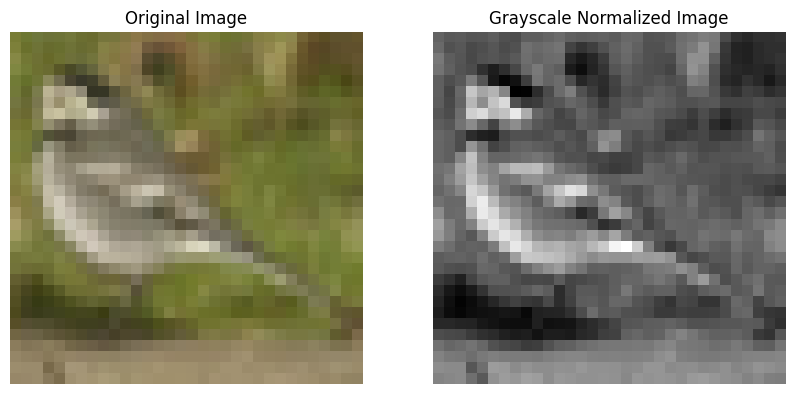

In [16]:
show_image(testset, norms_test, bird_indices[3], inv_normalize)

## Generate ZKML for Resnet and SVC models

In [17]:
# here we create and (potentially train a model)

# make sure you have the dependencies required here already installed
import json
#import numpy as np
from sklearn.svm import SVC
import sk2torch
#import torch
import ezkl
import os

import warnings
warnings.filterwarnings('ignore')

In [18]:
async def async_function(data_path, model_path, settings_path, resource_string):
    res = await ezkl.calibrate_settings(data_path, model_path, settings_path, resource_string)
    assert res == True

folder = "./tmp/"

# Create the directory 'tmp' in the current working directory
try:
    os.makedirs(folder, exist_ok=True)
    print(f"Directory '{folder}' created successfully")
except OSError as error:
    print(f"Directory '{folder}' cannot be created. Error: {error}")

Directory './tmp/' created successfully


In [19]:
def gen_SVC_verifier(model, grayscale_img, agg = False):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')
    cal_data_path = os.path.join(folder, 'cal_data.json')

    #srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')
    proof_path = os.path.join(folder, 'proof.json')

    grayscale_img = grayscale_img.reshape(1,-1)
    model = sk2torch.wrap(model)
    x = torch.from_numpy(grayscale_img)
    torch_out = model.predict(x)

    torch.onnx.export(model,               # model being run
                    # model input (or a tuple for multiple inputs)
                    x,
                    # where to save the model (can be a file or file-like object)
                    model_path,
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=10,          # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names=['input'],   # the model's input names
                    output_names=['output'],  # the model's output names
                    dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                    'output': {0: 'batch_size'}})

    d = ((x).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_shapes=[grayscale_img.shape[1:]],
                input_data=[d],
                output_data=[o.reshape([-1]).tolist() for o in torch_out])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    #cal_data = dict(input_data = )

    !RUST_LOG=trace
    # TODO: Dictionary outputs
    res = ezkl.gen_settings(model_path, settings_path)
    assert res == True

    res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")  # Optimize for resources
    #res = async_function(data_path, model_path, settings_path, "resource")

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs(settings_path)

    res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)
    
    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    # GENERATE A PROOF
    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "single", # for aggregated EVM proof only ELSE 'evm'
        )
    print ('Successfully generate ZK Proof!')
    #print(res)
    assert os.path.isfile(proof_path)

    # verify our proof
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
        )

    assert res == True
    print("verified")

In [ ]:
gen_SVC_verifier(SVC_model, x_test[0])

In [31]:
model = SVC_model
grayscale_img = x_test[0]

In [32]:
model_path = os.path.join(folder, 'network.onnx')
compiled_model_path = os.path.join(folder, 'network.compiled')
settings_path = os.path.join(folder, 'settings.json') 
witness_path = os.path.join(folder, 'witness.json')
data_path = os.path.join(folder, 'input.json')
cal_data_path = os.path.join(folder, 'cal_data.json')

srs_path = os.path.join(folder, 'kzg.srs')

pk_path = os.path.join(folder, 'test.pk')
vk_path = os.path.join(folder, 'test.vk')
proof_path = os.path.join(folder, 'proof.json')

grayscale_img = grayscale_img.reshape(1,-1)
model = sk2torch.wrap(model)
x = torch.from_numpy(grayscale_img)
torch_out = model.predict(x)

torch.onnx.export(model,               # model being run
                # model input (or a tuple for multiple inputs)
                x,
                # where to save the model (can be a file or file-like object)
                model_path,
                export_params=True,        # store the trained parameter weights inside the model file
                opset_version=10,          # the ONNX version to export the model to
                do_constant_folding=True,  # whether to execute constant folding for optimization
                input_names=['input'],   # the model's input names
                output_names=['output'],  # the model's output names
                dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                'output': {0: 'batch_size'}})

d = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_shapes=[grayscale_img.shape[1:]],
            input_data=[d],
            output_data=[o.reshape([-1]).tolist() for o in torch_out])

# Serialize data into file:
json.dump(data, open(data_path, 'w'))

In [33]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = async_function(data_path, model_path, settings_path, "resource")
#assert res == True

In [ ]:
#await res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")

In [34]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [27]:
res = ezkl.get_srs(srs_path, settings_path)

In [28]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )
 

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

spawning module 2
spawning module 2


In [29]:
res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [35]:
proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "single",
    )

print(proof)
assert os.path.isfile(proof_path)

spawning module 2


{'instances': [[[8895048820941913435, 12590578388187041751, 10644156957292843428, 485414809211466155]]], 'proof': '2f2d50ab9d5b29232ce4630b29eb647a0d7d5388ca4186bb7fc6bffd417fe13a1ce543de7f92fc040a4e171de895949726c7bc29f7b16cf61cb56fc6c13502552edbd8459651b21b4e4531378ffc3e1cae98b87576c9f33cbcf25bbe8b4ba0222b65a6fdc4813d8baa7b5be50805b0ec118d9c71b90c0030399763639fc8316a220a64c6b841a9cac26cb205d341ba6b158b6b6eb4d99e4fa905c1405092f1d910de0465ff013916e3a9003aee90a72638a4e5f95aabbba5b2b4e067be2ad31c2c8df9768dda759b2255efe350827c34b05066c5f79fdf8237d7e568293ce8680e6993454fd63f954fc7e455b02de5d355748a046500355ca5998a382a71c6ac1042cde03870ec590503fd61f91004e36f372cb49dcca8208992c6ccae9c83181ac971daa9e27202c69bb0dc8385ab628edfae99b7c7cc4ee230c63a70c70dad0a0fcb38a04bfe29df95a4f1f31da7f9cebbe23980e6fd7ac86c6d938ab441961cfe75dd8bdef899b045a74afa8dca229e29d2eadfe31c20730929176de900801f317fa0bcdf32ff8ab2cc4dce766294d1d1bfde2300231596ad2bfcc28c6cdb04b8f006aade78fa515b5dad26c8a251133d0f57d14a0c8c15344

In [36]:
# verify our proof
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

verified
